# Wall Thickness Workflow

$_{Yongtao}$ $_{Liu,}$  
$_{youngtaoliu@gmail.com}$

$_{Feb}$ $_{2024}$


Piezoresponse force microscopy (PFM) is a powerful technique to study ferroelectrics at the nanoscale. In PFM measurements, an AC voltage is applied to the sample surface through tip and the response of the material is detected, allowing researchers to characterize ferroelectric domains and domain walls. However, the behavior of ferroelectric domain walls can be influenced by the AC voltage and the force (i.e., driven amplitude and set point) applied to the sample surface. We have the chance to optimize the imaging conditions to better characterize and study ferroelectric domain walls by carefully choosing these parameters. 

This notebook is the workflow to study ferroelectric domain walls as a function of drive amplitude and setpoint. This notebook contains two parts: first is experimentation, second is data analysis. Both parts work independently. 



## Experiment

### Import

In [ ]:
import os
import win32com.client
import numpy as np
import time
import h5py
import sidpy
import pyNSID
import matplotlib.pyplot as plt
from tqdm import tqdm
from AEcroscopy import Acquisition

### Start BEPyAE.exe and set VI

* Start BEPyAE.ext
* Set VI of BEPyAE; if this version includes PyScanner, also set VIs for PyScanner

In [ ]:
newexp = Acquisition(exe_path = r"C:\Users\BEPyAE 060523 01\BEPyAE.exe")   
# exe_path is the directory of BEPyAE; 

### Initialize Igor AR18
* Set offline development
* Build a connection between BEPyAE and AR18
* Get parameters in AR18

In [ ]:
newexp.init_BEPyAE(offline_development = False) # set offline_development=True if doing offline development
                                                # executing this will also initlize AR18

### Set tip parameters
* set setpoint, tip locations

In [ ]:
newexp.tip_control(tip_parms_dict = {"set_point_V_00": 1, "next_x_pos_00": 0, "next_y_pos_01": 0},
                   do_move_tip = True, 
                   do_set_setpoint = True) # Executing this code will set setpoint to 1 V, 
                                           # and move tip to location [0, 0]

### Set IO 
This defines IO parameters, such as AFM platform: AR18, amplifiers, channel data types, etc

In [ ]:
newexp.define_io_cluster(IO_cluster_parms_dict = {"analog_output_amplifier_06": 1, 
                                                  "channel_01_type_07": 1, 
                                                  "channel_02_type_08": 2,
                                                  "channel_03_type_09": 3,})

### Set BE pulse parameters 

In [ ]:
# set BE parameters
newexp.define_be_parms(be_parms_dict = {"center_frequency_Hz_00": 350, "band_width_Hz_01": 100, "amplitude_V_02": 1, 
                                        "phase_variation_03": 1, "repeats_04": 4, "req_pulse_duration_s_05": 4,
                                        "auto_smooth_ring_06": 1},
                       do_create_be_waveform = True)

### BE Line scan to check BE parameters
* This is a single BE line scan
* This returns 5 datasets: quick_fitting, complex spectra, and 3 channels

In [ ]:
# Do a single line scan
qk_fit, com_spec, chn1, chn2, chn3 = newexp.do_line_scan(line_scan_parms_dict = {"num_BE_pulses_01": 32,
                                                                                 "start_x_pos_00": -1, "start_y_pos_01": -1,
                                                                                 "stop_x_pos_02": 1, "stop_y_pos_03": 1},
                                                         upload_to_daq = True, do_line_scan = True)

### Prior to expeirment, set a directory to save data

In [ ]:
os.chdir(r"D:\WEST User data\Experiment")

## Experiment starts

### Step 1. Establish AC Amplitude and Setpoint Parameters

In [ ]:
# uniformly distributed AC amplitude
min_ac = 0.5
max_ac = 5
num_ac = 10
Vac = np.linspace(min_ac, max_ac, num_x)  # AC amplitude

# uniformly distributed setpoint values
min_setpoint = 0.5
max_setpoint = 5
num_setpoint = 10
setpoint = np.linspace(min_setpoint, max_setpoint, num_setpoint)  # Setpoint

# Establish AC and setpoint parameters array
Vac_setpoint = np.meshgrid(Vac, setpoint)
Vac = Vac_setpoint[0].reshape(-1)
setpoint = Vac_setpoint[1].reshape(-1)

print ("{} AC and setpoint parameters are ready for expierments".format(len(Vac)))
    
# save pulse condition
np.save("Vac_setpoint.npy", np.asarray([Vac, setpoint]))

### Step 2. Perform BEPFM to image the domain wall with various AC and setpoint 

In [ ]:
for i in tpdm(range(len(Vac))):
    # select AC and setpoint
    be_amp = Vac[i]
    spoint = setpoint[i]
    # Set setpoint
    newexp.tip_control(tip_parms_dict = {"set_point_V_00": spoint}, do_move_tip = False, do_set_setpoint = True)
    # Set BE pulse amplitude
    newexp.define_be_parms(be_parms_dict = {"center_frequency_Hz_00": 335, "band_width_Hz_01": 100, "amplitude_V_02": be_amp},
                           do_create_be_waveform = True)
    
    # Perform BEPFM image measurement
    dset_pfm, dset_chns, dset_cs = newexp.raster_scan(raster_parms_dict = {"tip_voltage": 0, "scan_pixel": 128, 
                                                                           "scan_x_start": -1.0, "scan_y_start": -1.0,
                                                                           "scan_x_stop": 1.0, "scan_y_stop": 1.0},
                                                      file_name = "Domain_wall_width", ploton = False)

    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize = (30, 5), dpi = 100)
    ax1.imshow(dset_pfm[:,:,0], origin = "lower"); ax1.set_title("Amplitude")
    ax2.imshow(dset_pfm[:,:,1], origin = "lower"); ax2.set_title("Frequency")
    ax3.imshow(dset_pfm[:,:,2], origin = "lower"); ax3.set_title("Q Factor")
    ax4.imshow(dset_pfm[:,:,3], origin = "lower"); ax4.set_title("Phase")
    ax5.imshow(dset_chns[0,:,:], origin = "lower"); ax5.set_title("Topography")
    ax6.imshow(dset_chns[1,:,:], origin = "lower"); ax6.set_title("Deflection")
    plt.show()

## Post Experiment Data Analysis

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sidpy
import cv2
import imutils

## Set the directory and root name of your dataset

In [2]:
# directory
path = r"C:\Users\Experiment"

## Load all data

In [3]:
count_imgs = 64 # variable of how many images you have in the directory
pixel = 64  # pixel of your image

# change working directory
os.chdir(path)

# create arrays for all data
amplitude = np.zeros((count_imgs, pixel, pixel))
phase = np.zeros((count_imgs, pixel, pixel))
frequency = np.zeros((count_imgs, pixel, pixel))
qfactor = np.zeros((count_imgs, pixel, pixel))
topography = np.zeros((count_imgs, pixel, pixel))

for i in range (count_imgs):
    h5 = h5py.File('Domain_wall_width_1um_{}_0.hf5'.format(i), 'r+')
    be_qf = h5["BE Quick Fitting/Quick Fitting/Quick Fitting"]
    be_ch = h5["BE Channels/Channels/Channels"]
    amplitude[i,] = be_qf[:,:,0]
    phase[i,] = be_qf[:,:,3]
    frequency[i,] = be_qf[:,:,1]
    qfactor[i,] = be_qf[:,:,2]
    topography[i,] = be_ch[0,:,:,0]

nor_amplitude = (amplitude-amplitude.min())/amplitude.ptp()
nor_phase = (phase - phase.min())/phase.ptp()
nor_frequency = (frequency - frequency.min())/frequency.ptp()
nor_topography = (topography - topography.min())/topography.ptp()

## Load Vac and Setpoint

In [6]:
vac_setpoint = np.load("Vac_setpoint.npy")
vac_setpoint

array([[0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 0.5, 1. , 1.5, 2. , 2.5,
        3. , 3.5, 4. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 0.5, 1. ,
        1.5, 2. , 2.5, 3. , 3.5, 4. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5,
        4. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 0.5, 1. , 1.5, 2. ,
        2.5, 3. , 3.5, 4. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. , 1. , 1. , 1. , 1. ,
        1. , 1. , 1. , 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 2. , 2. ,
        2. , 2. , 2. , 2. , 2. , 2. , 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
        2.5, 3. , 3. , 3. , 3. , 3. , 3. , 3. , 3. , 3.5, 3.5, 3.5, 3.5,
        3.5, 3.5, 3.5, 3.5, 4. , 4. , 4. , 4. , 4. , 4. , 4. , 4. ]])

## Plot data

Plot all results

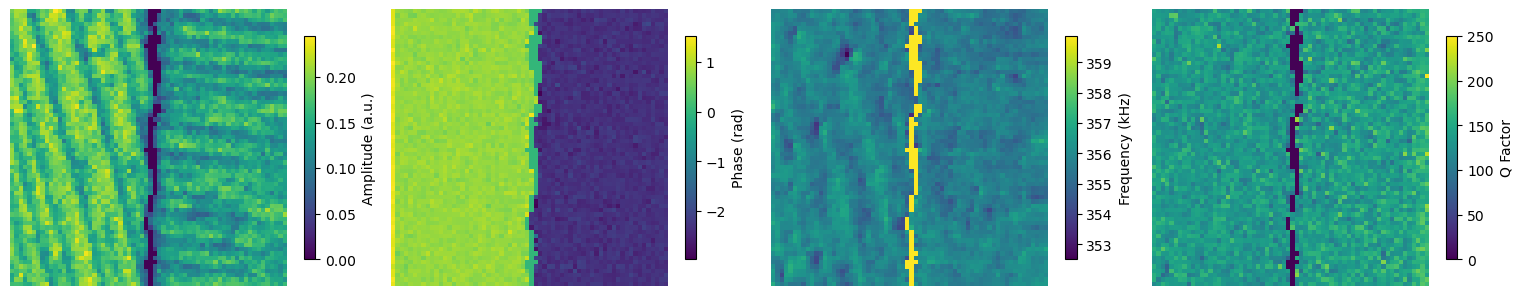

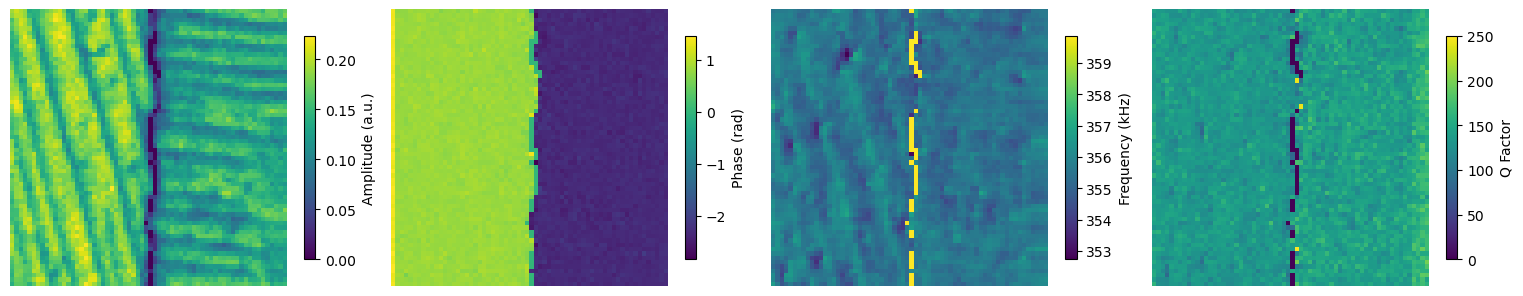

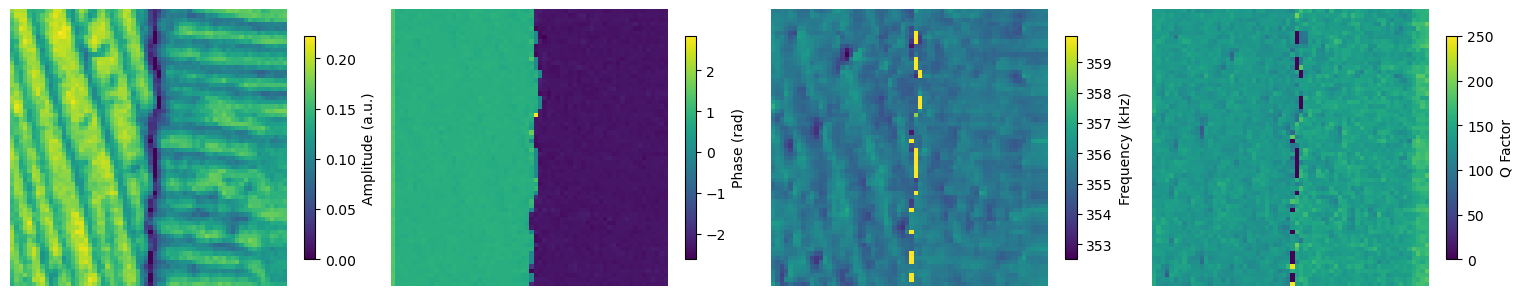

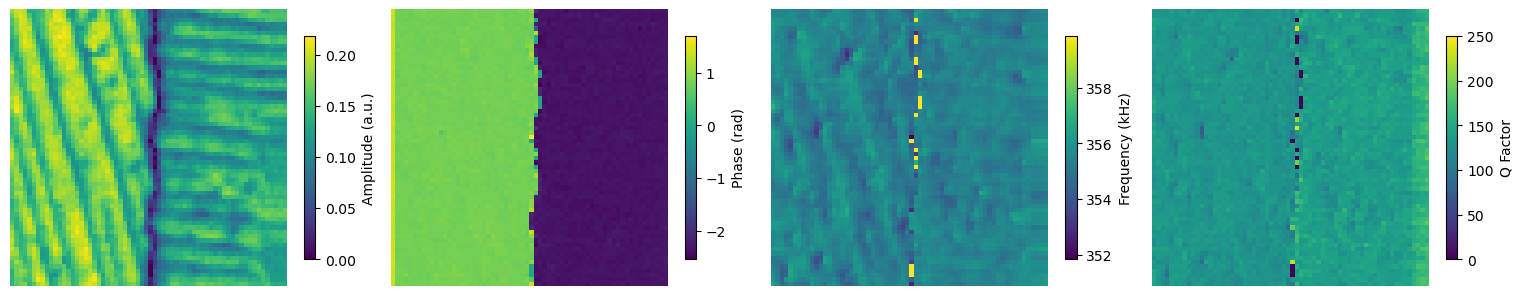

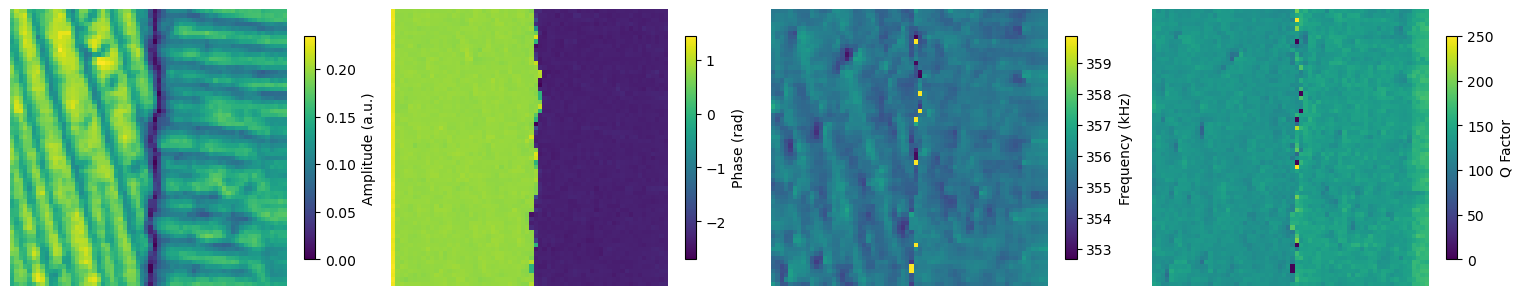

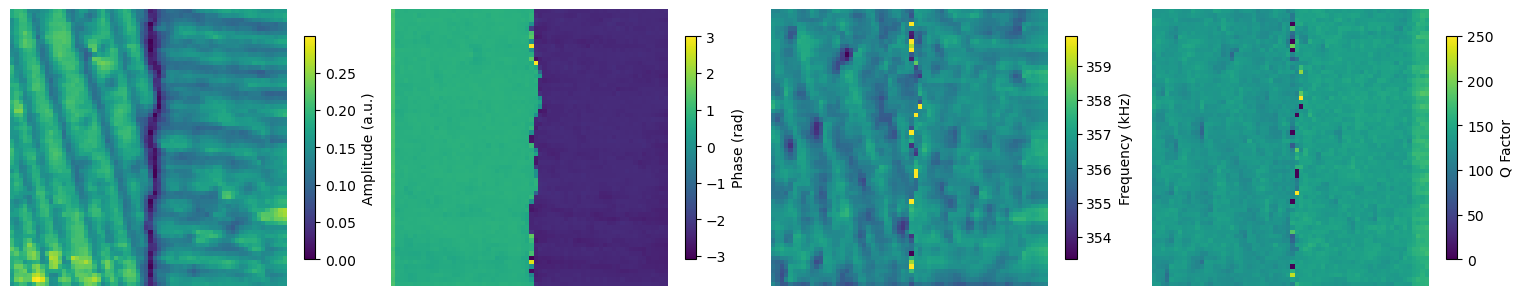

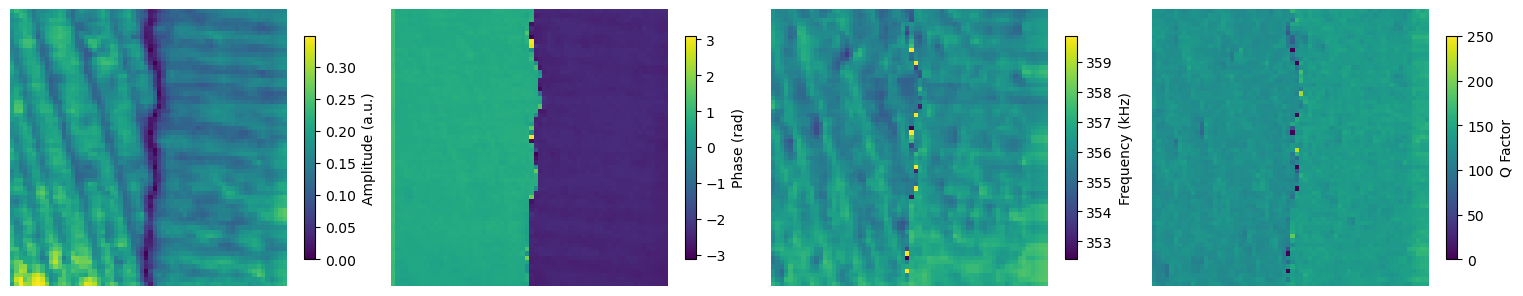

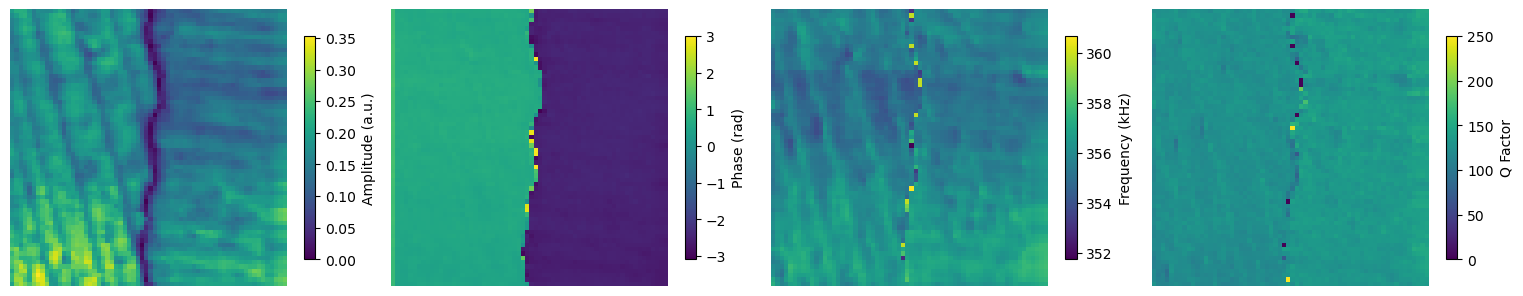

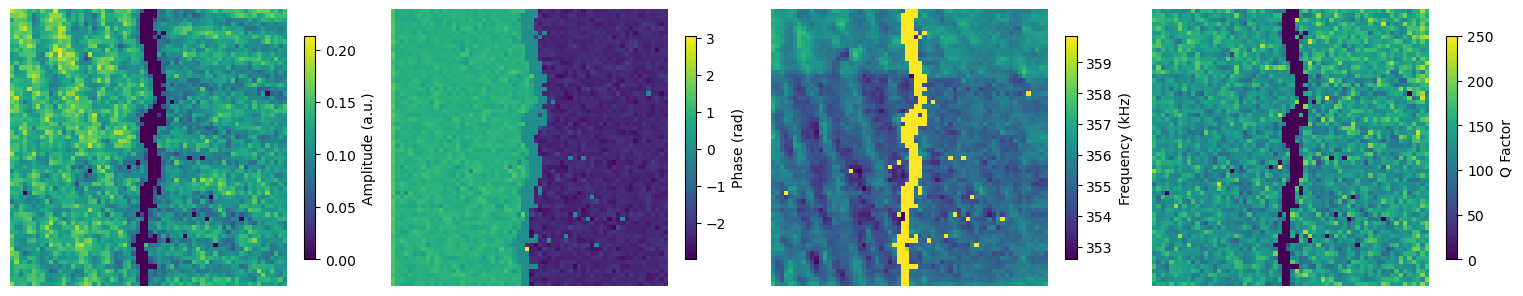

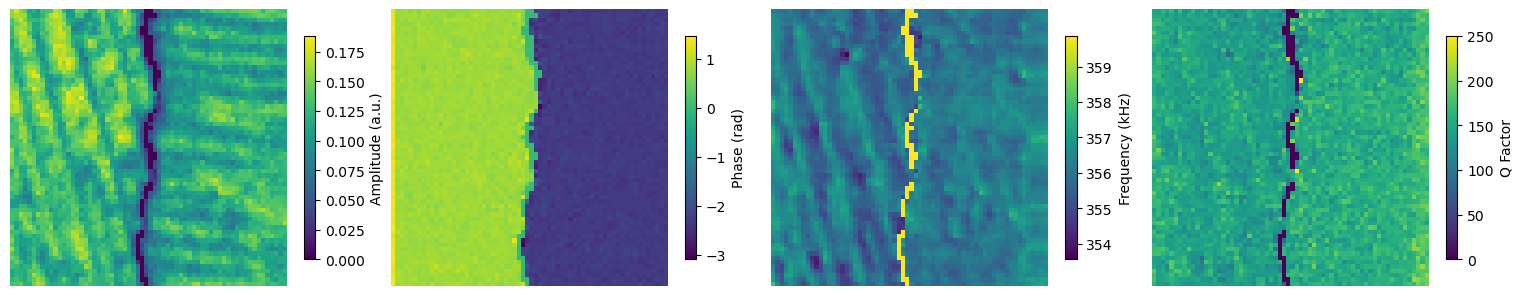

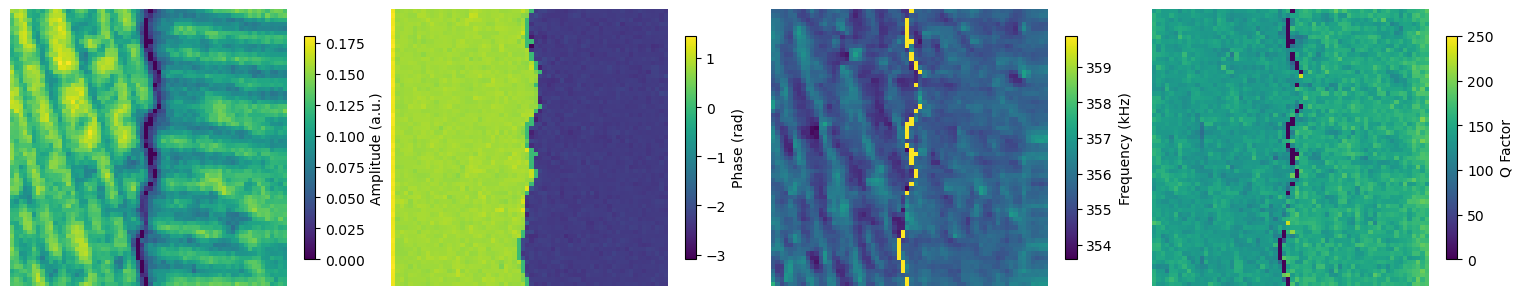

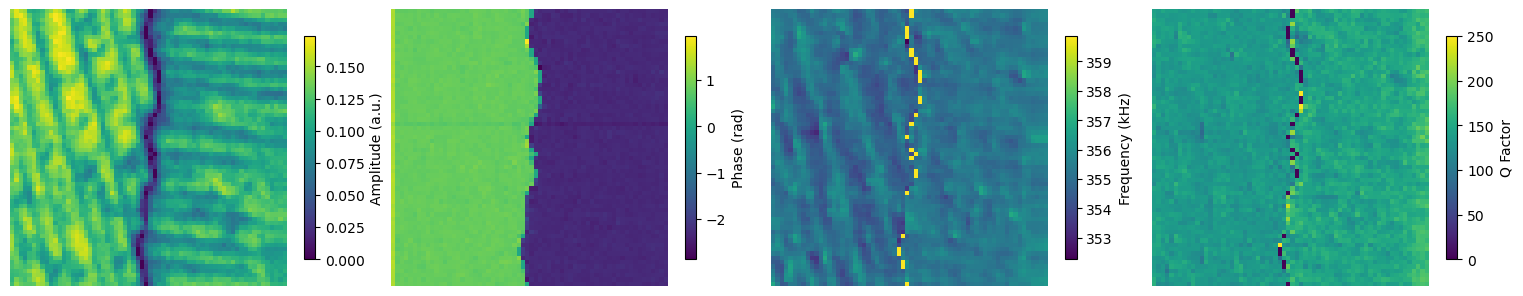

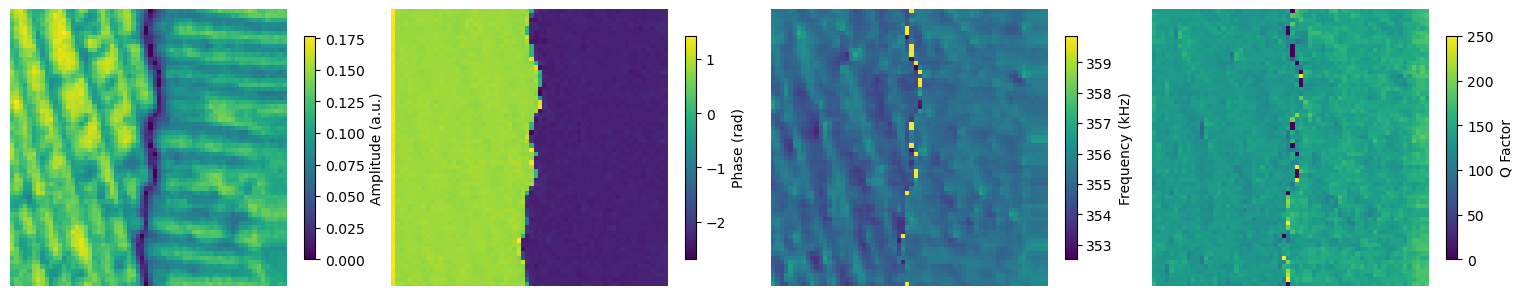

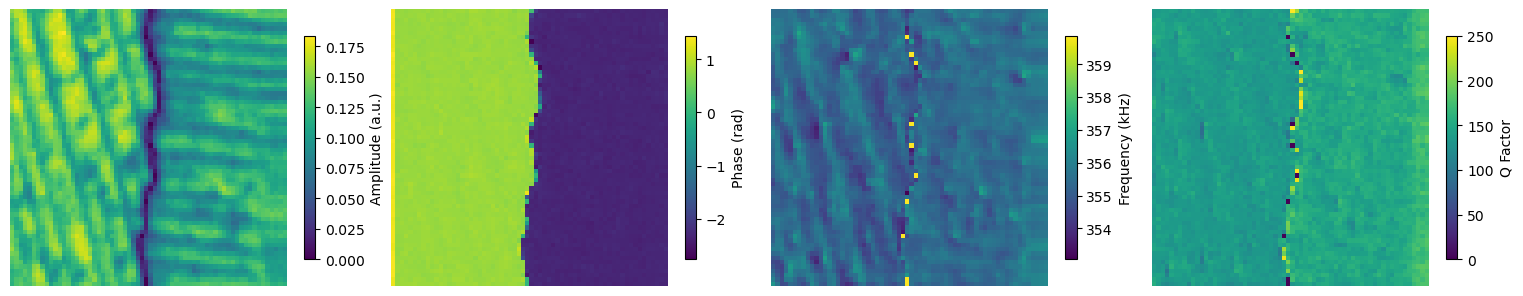

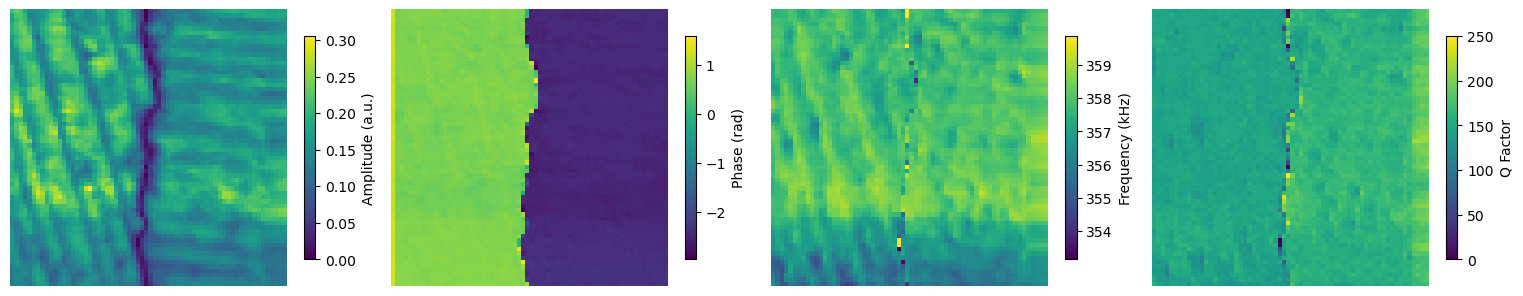

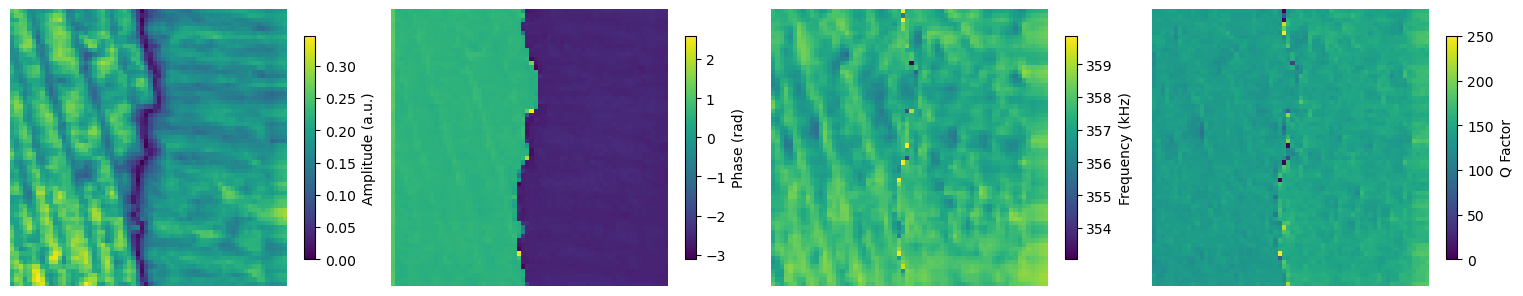

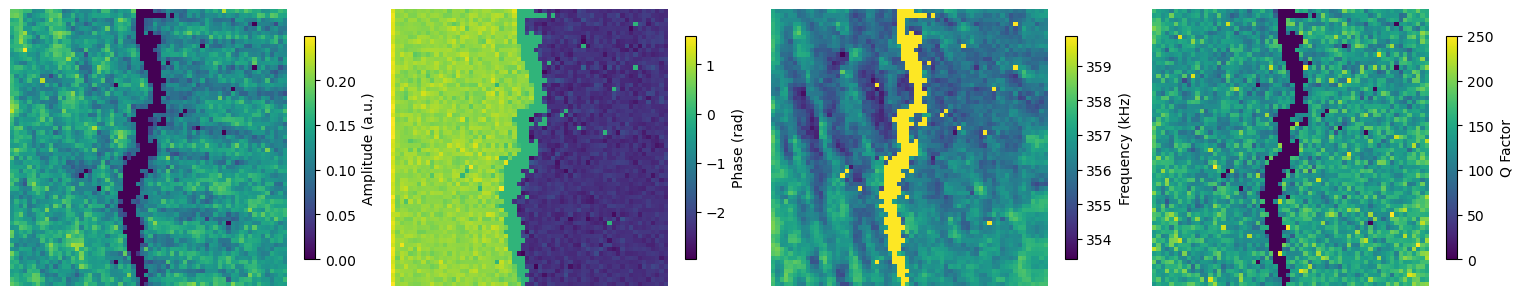

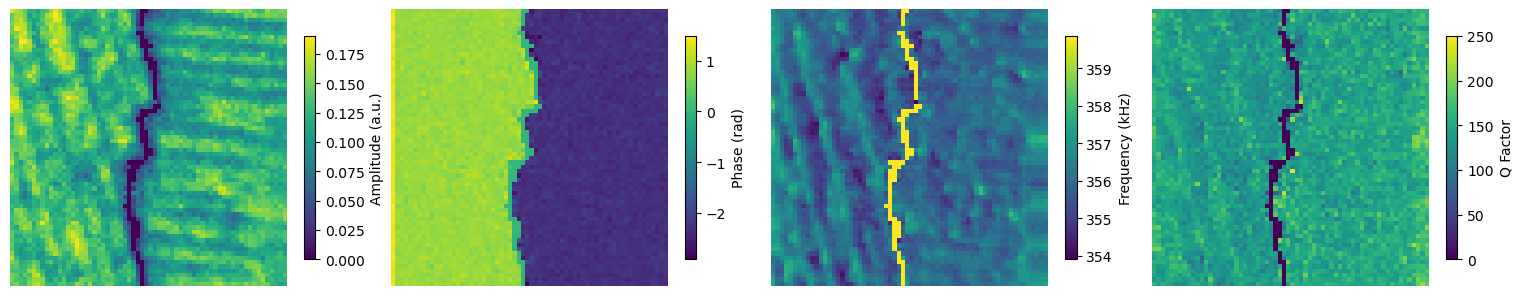

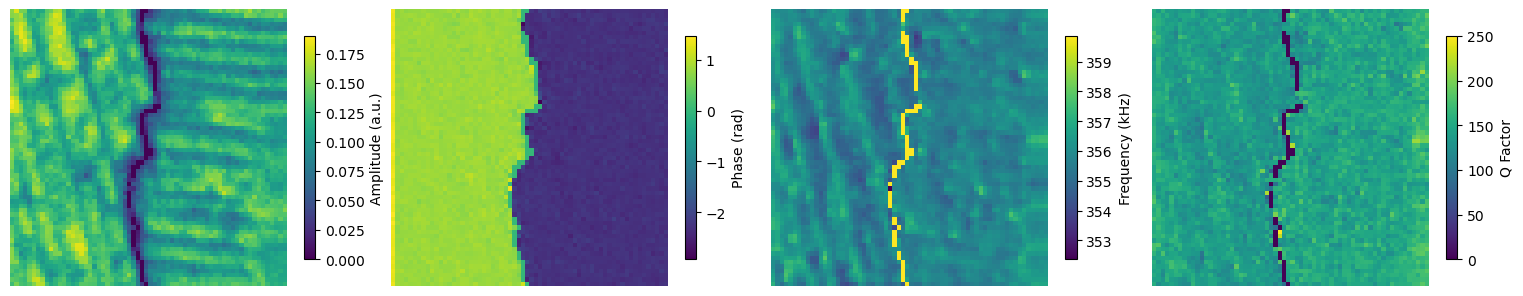

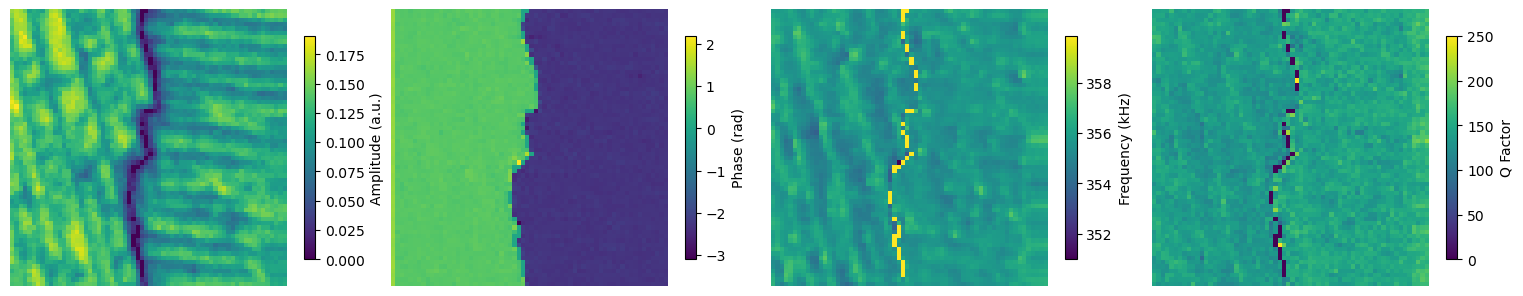

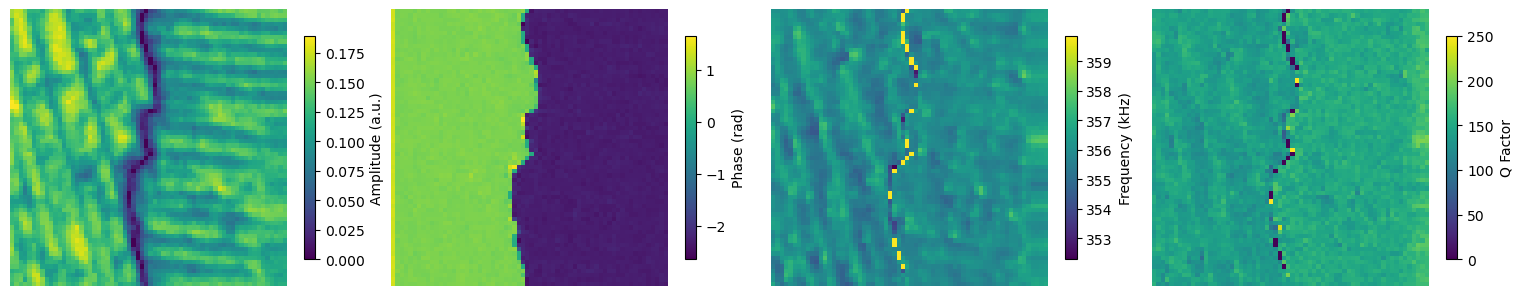

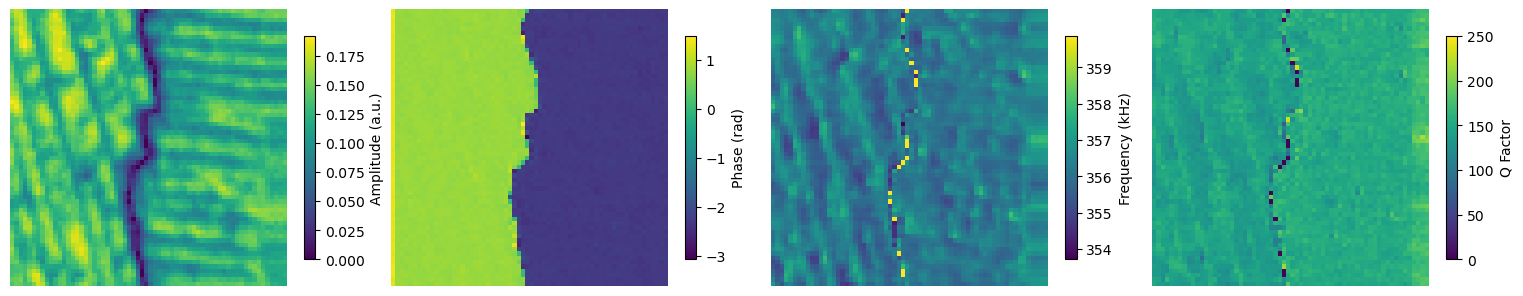

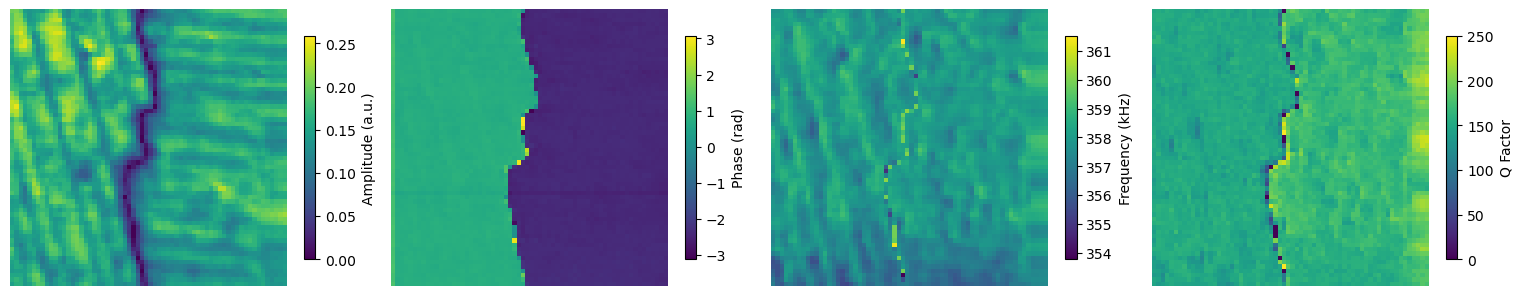

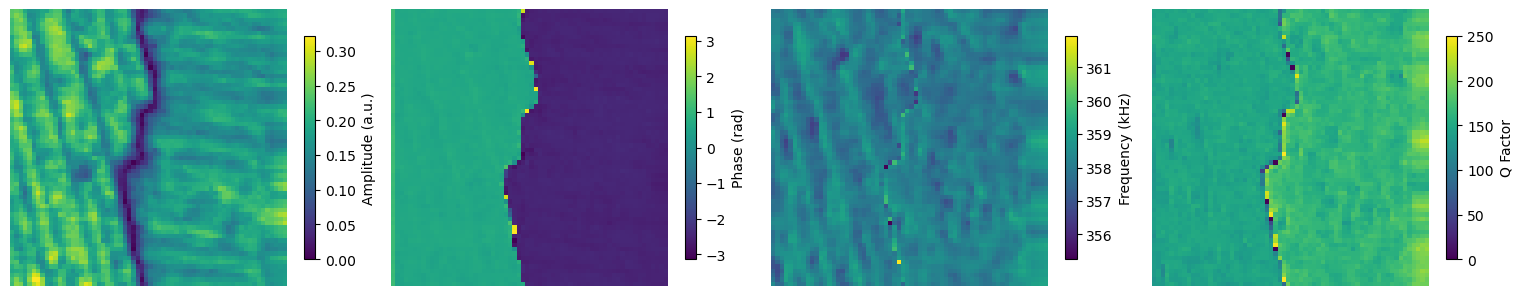

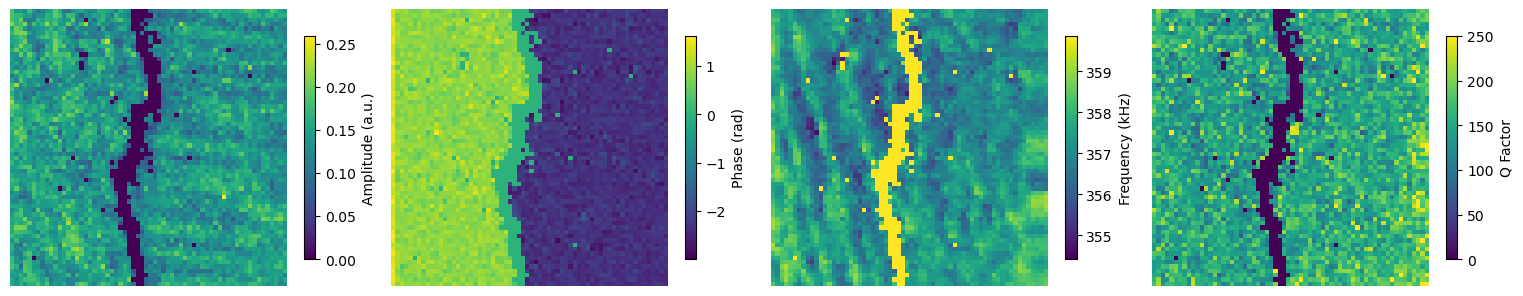

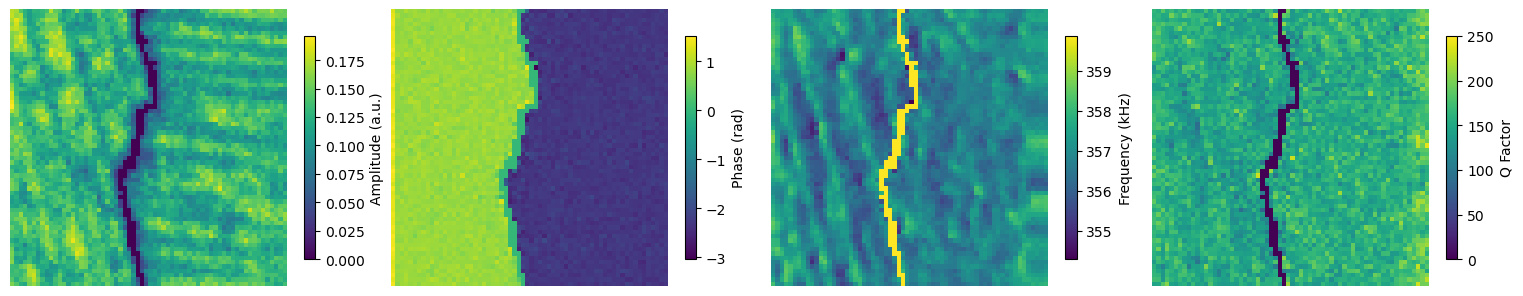

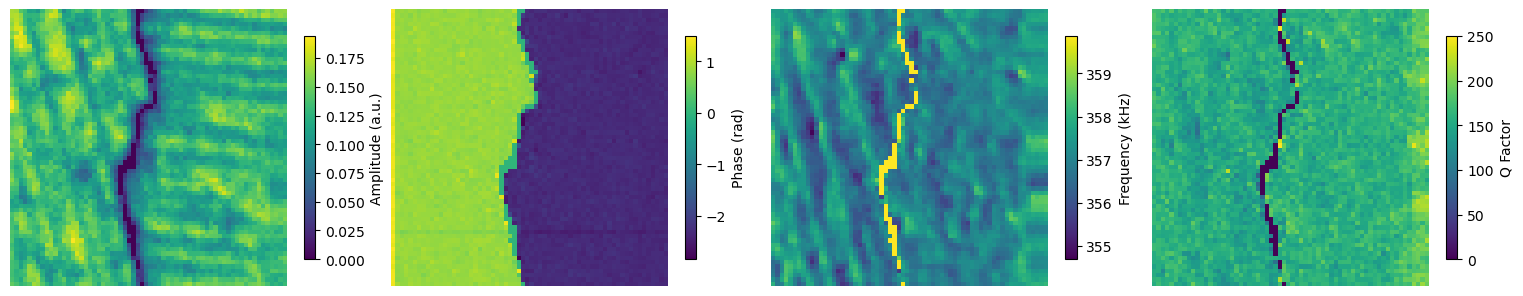

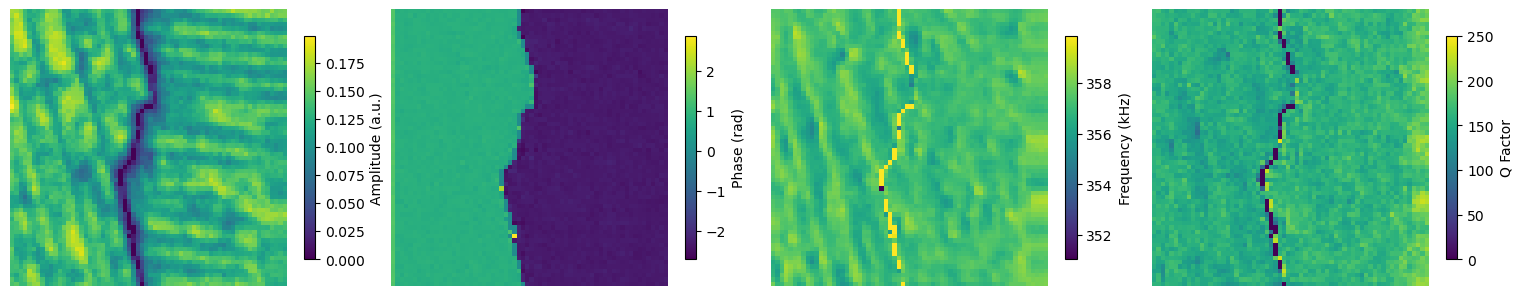

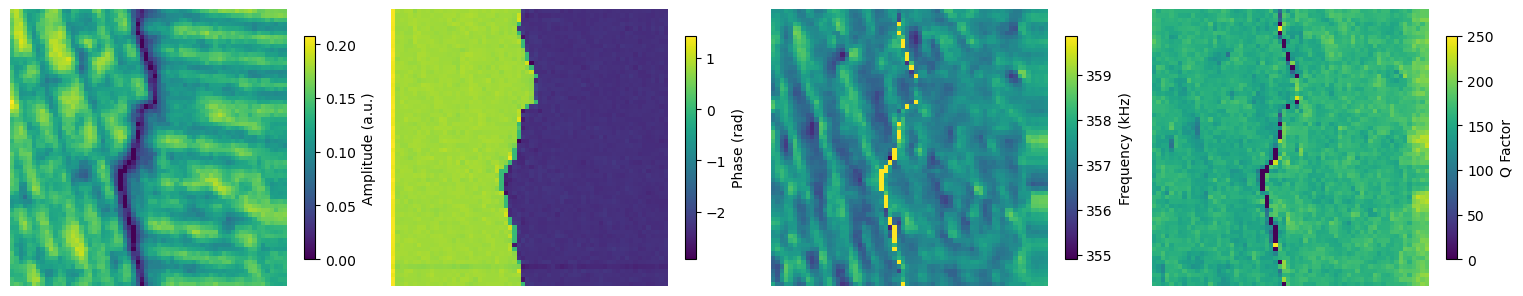

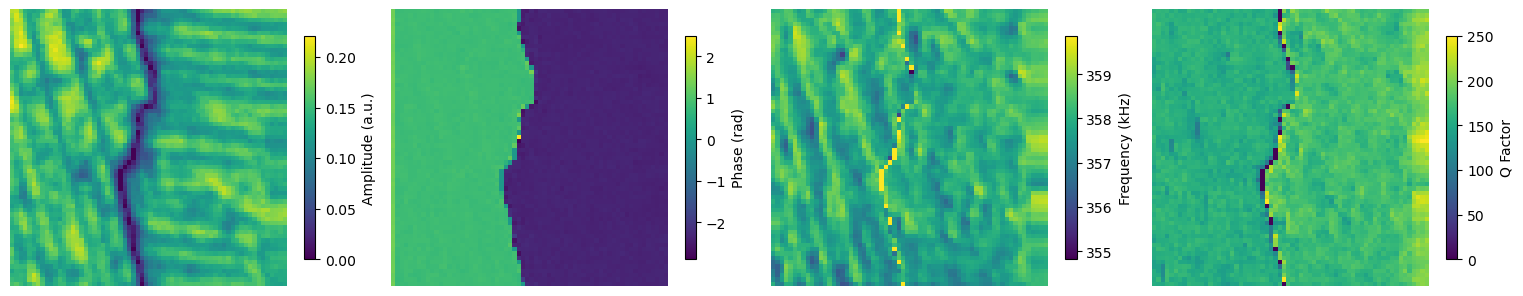

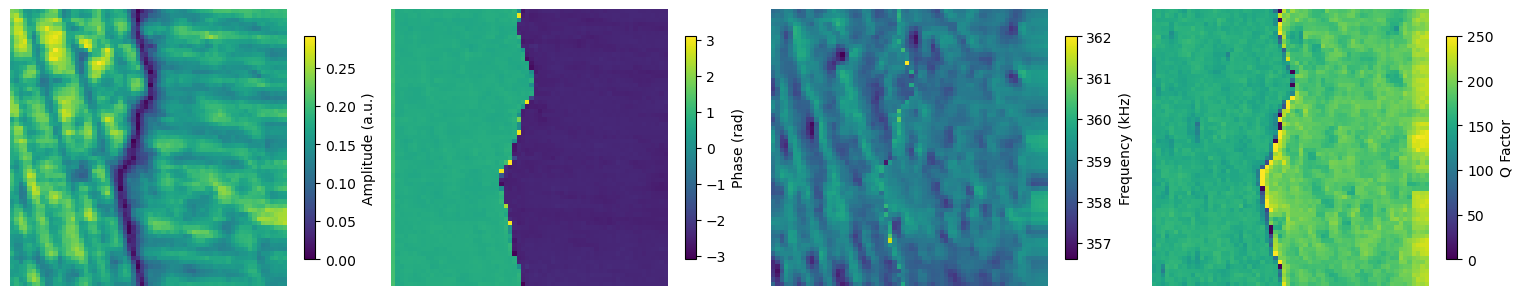

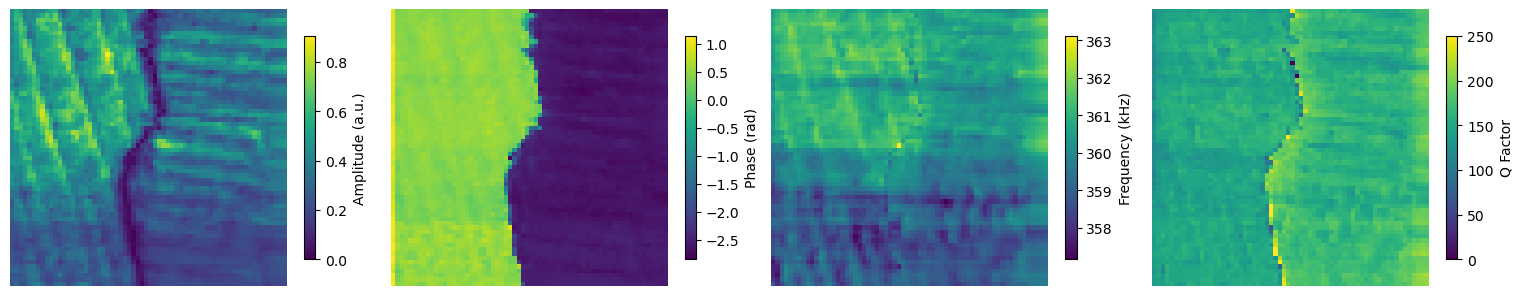

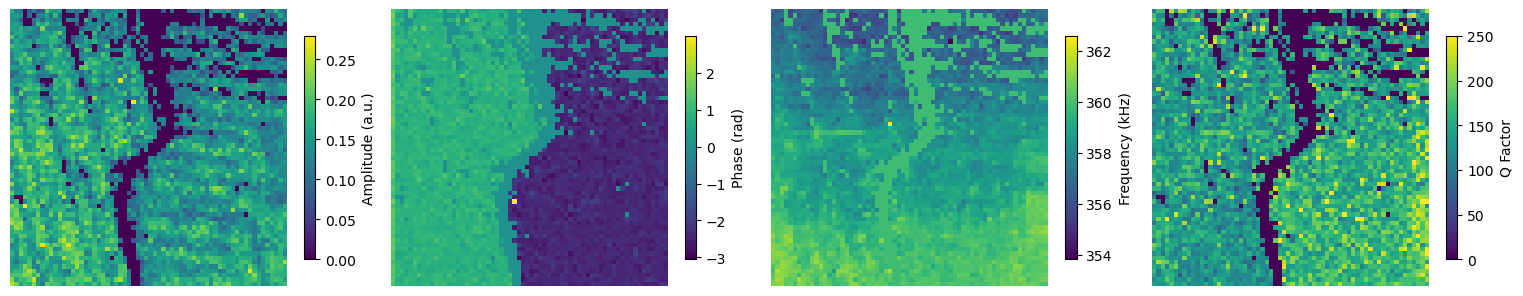

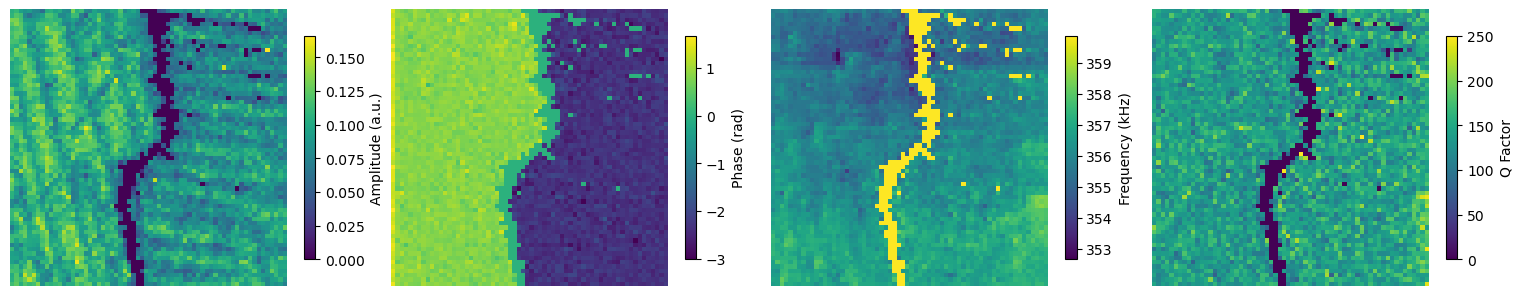

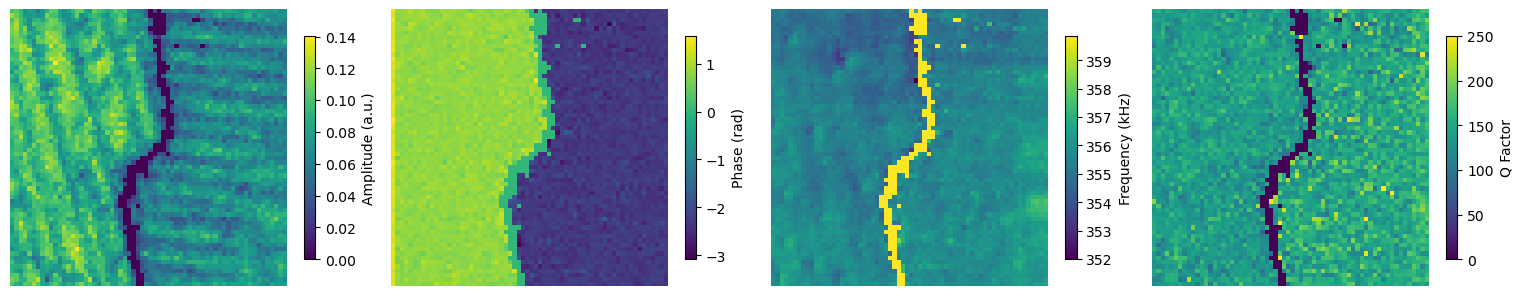

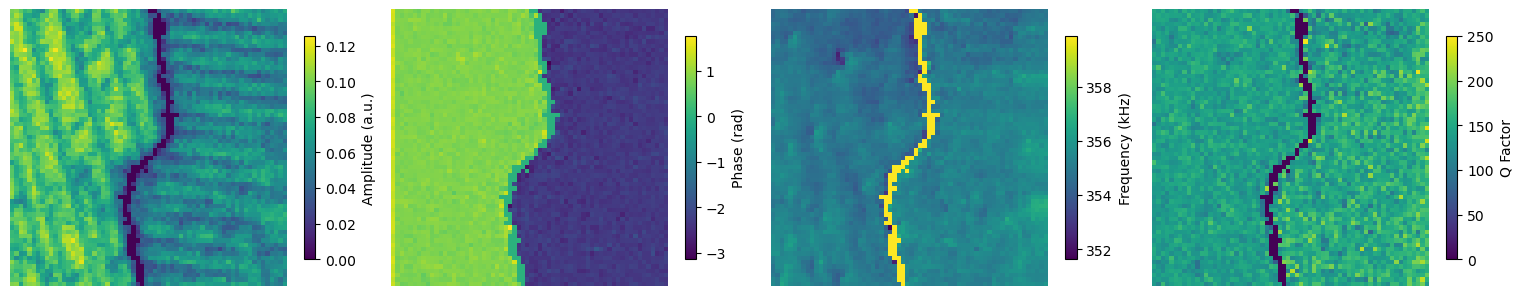

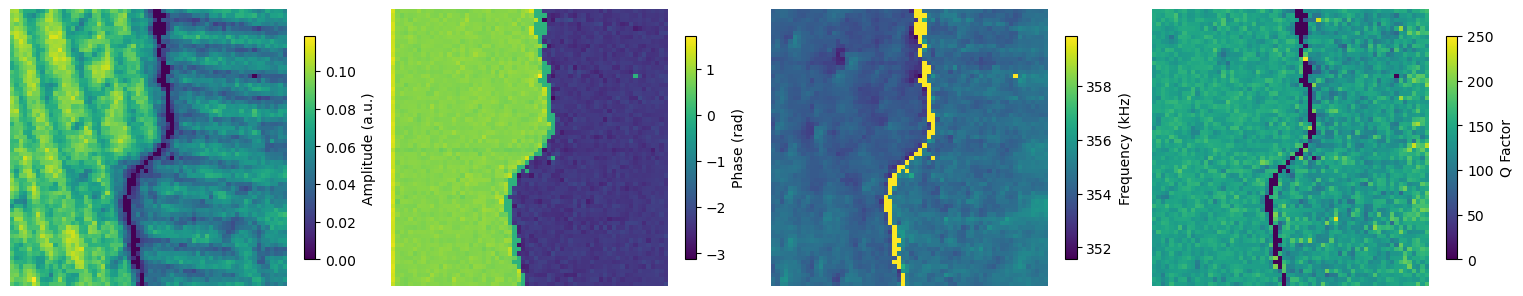

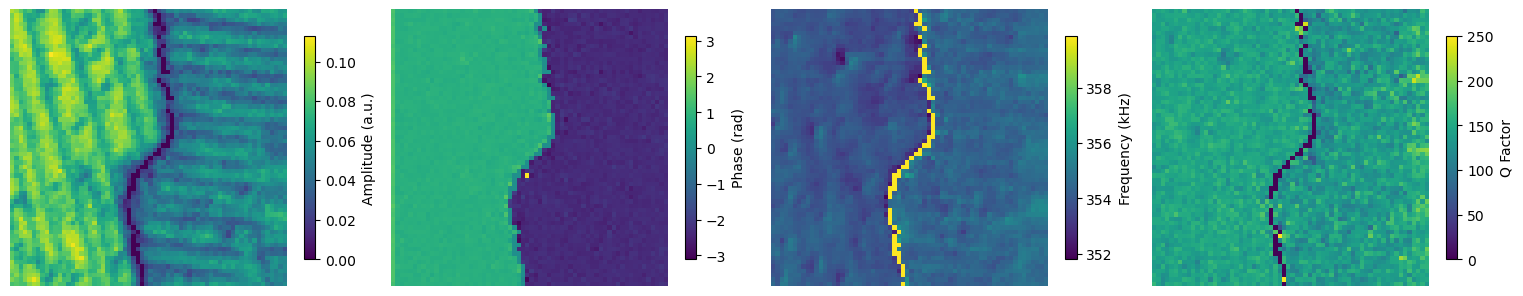

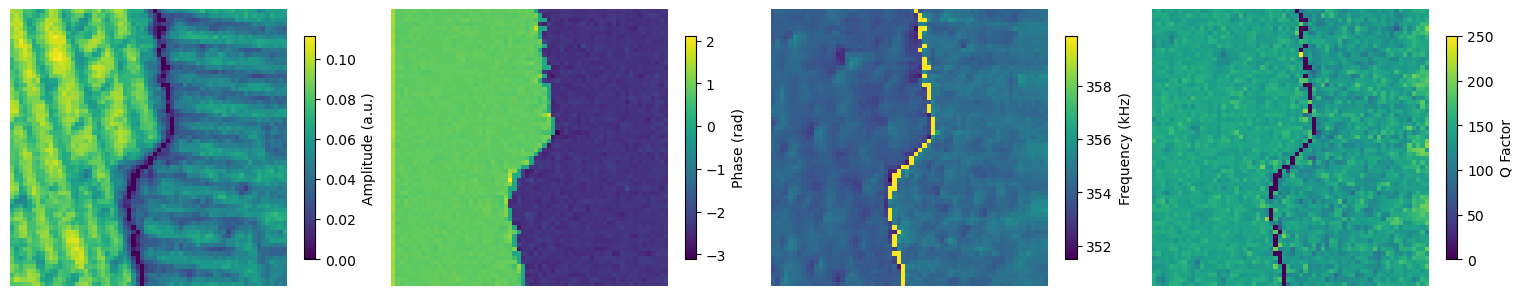

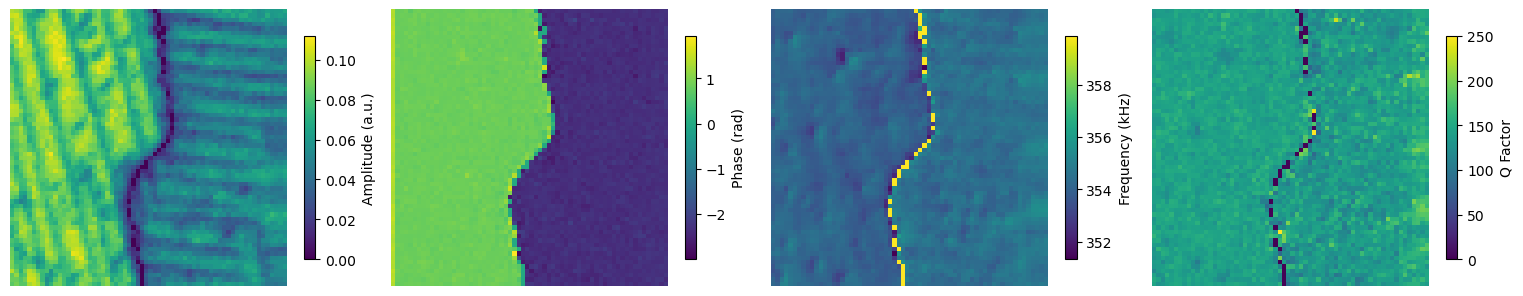

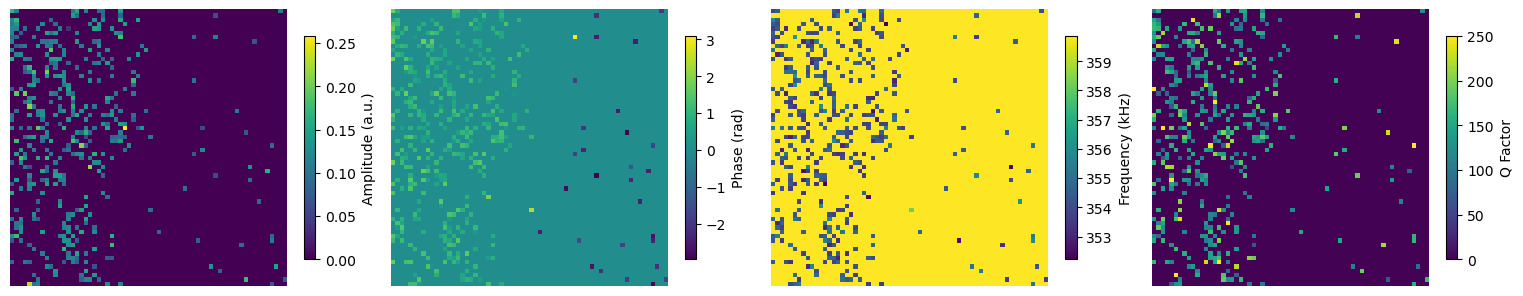

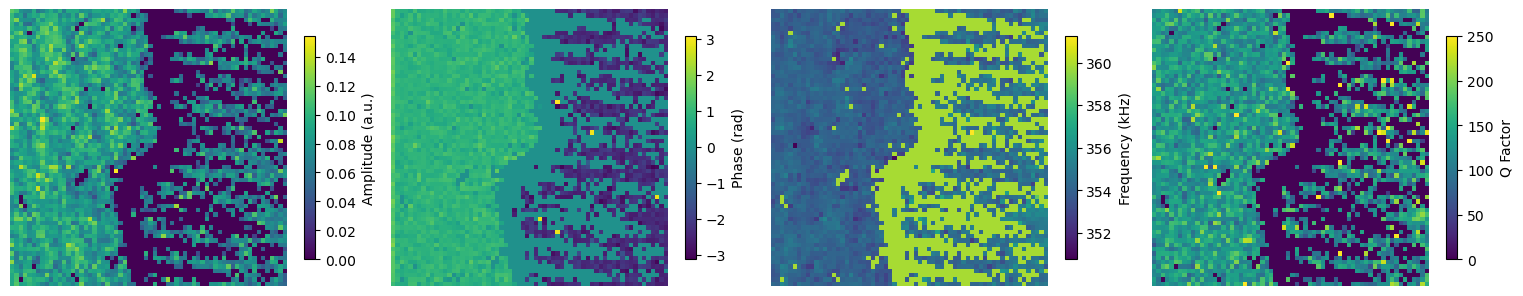

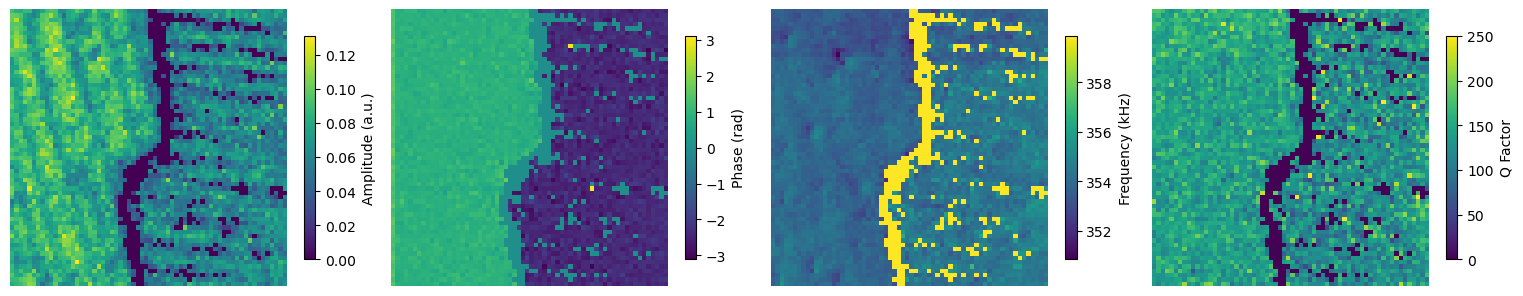

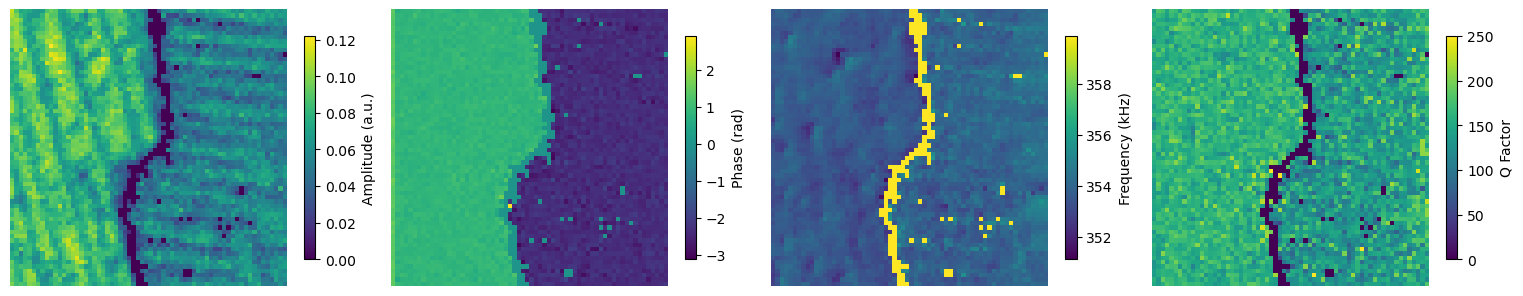

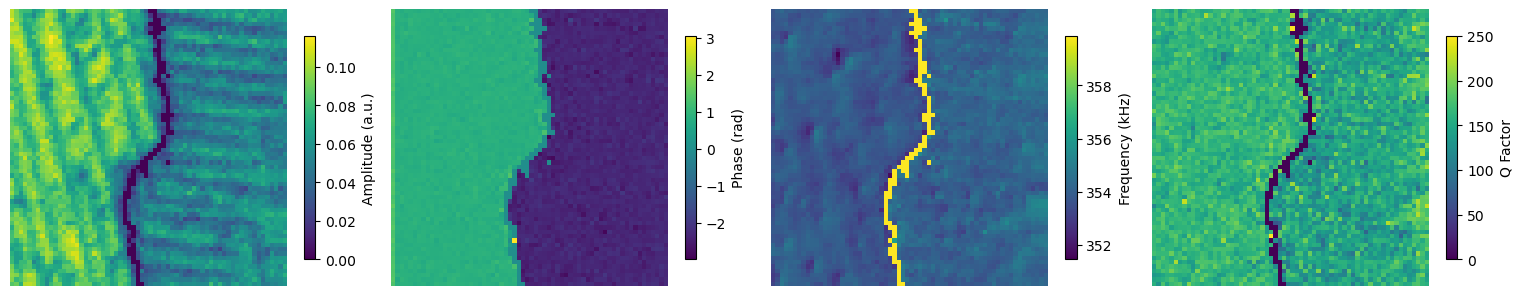

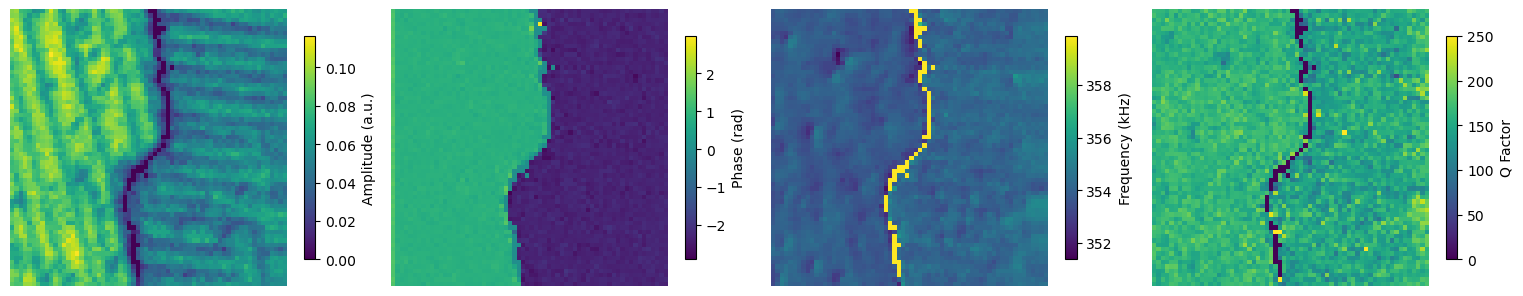

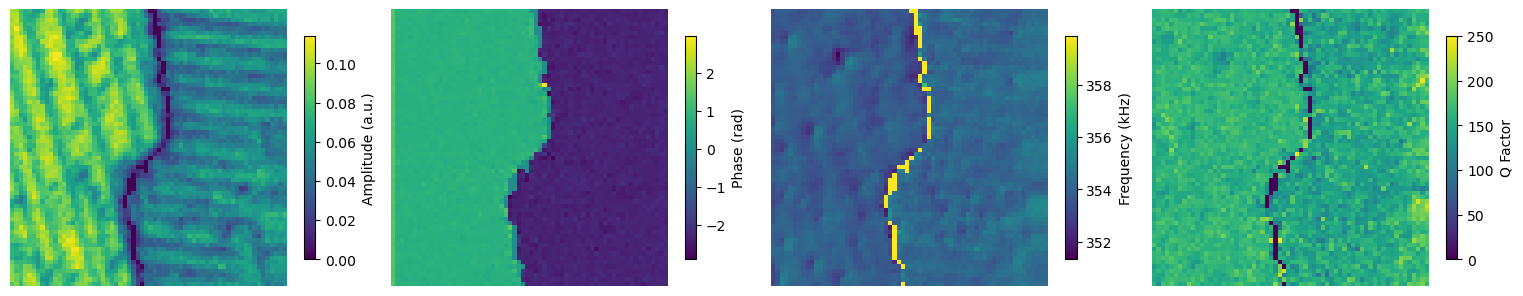

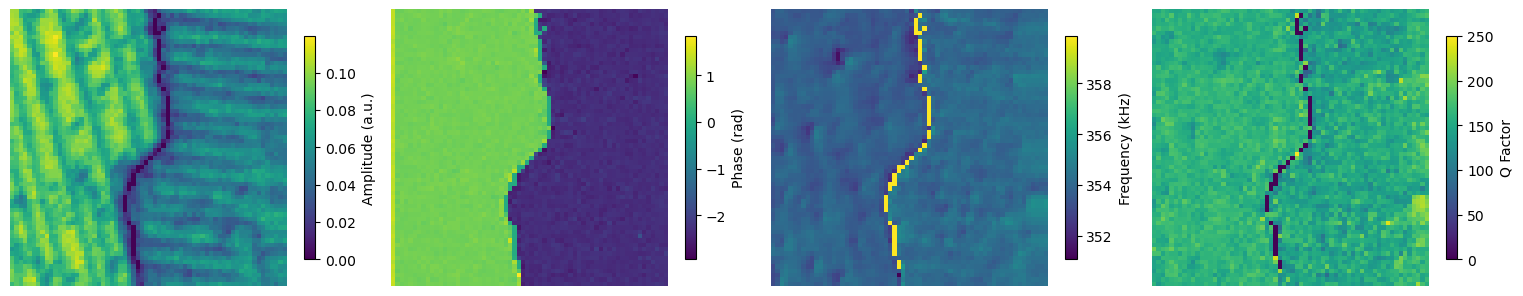

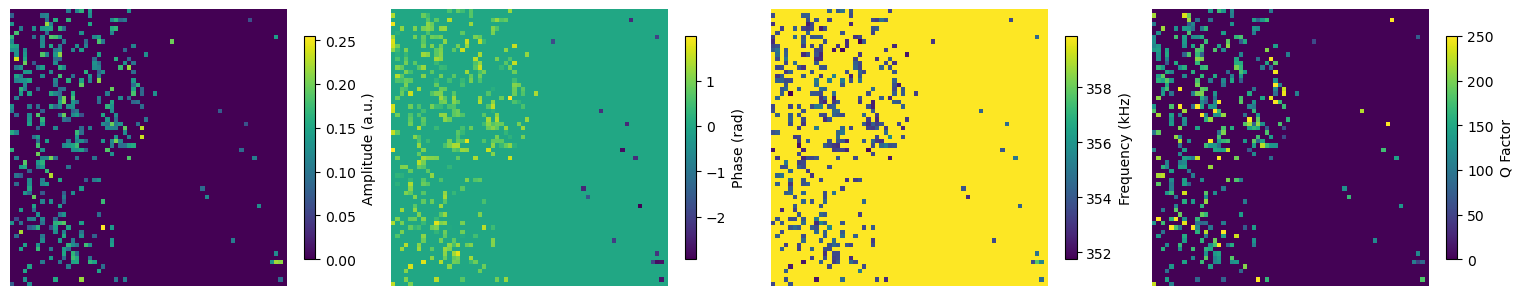

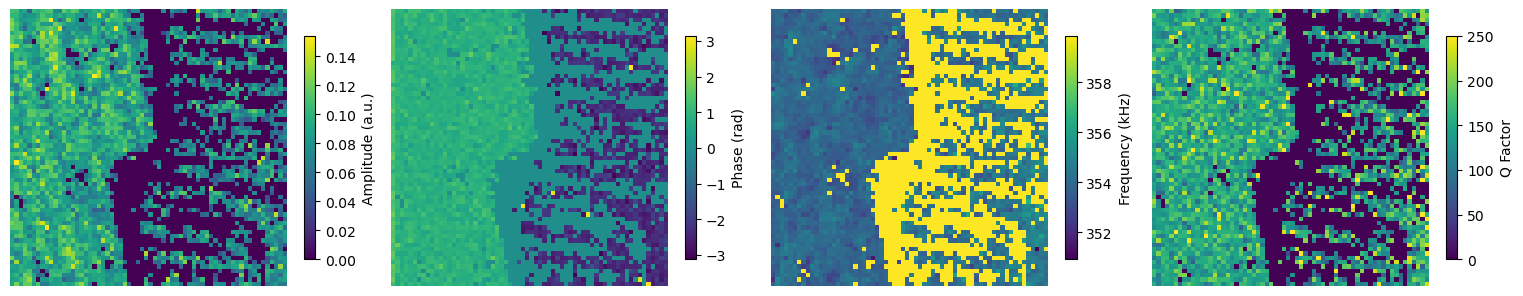

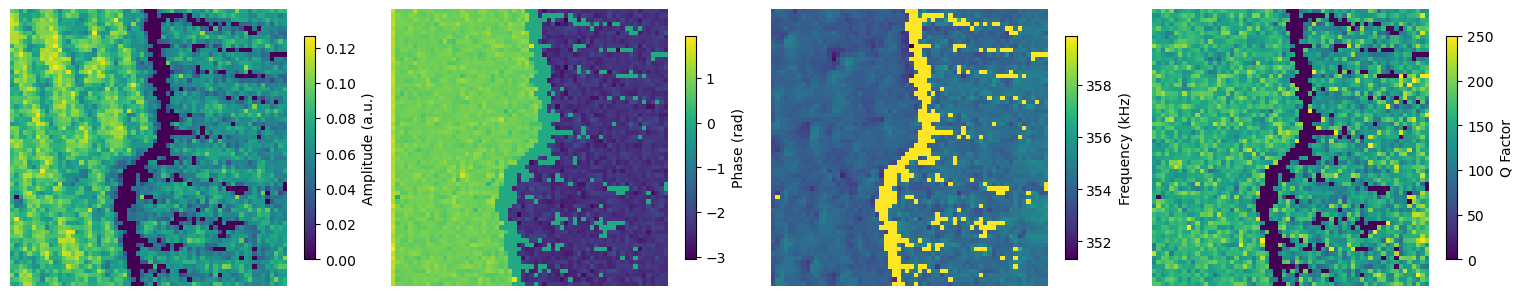

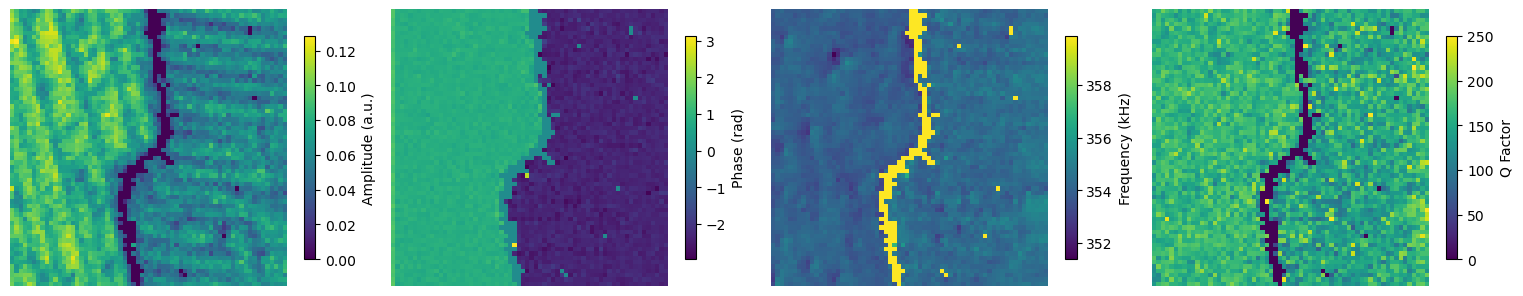

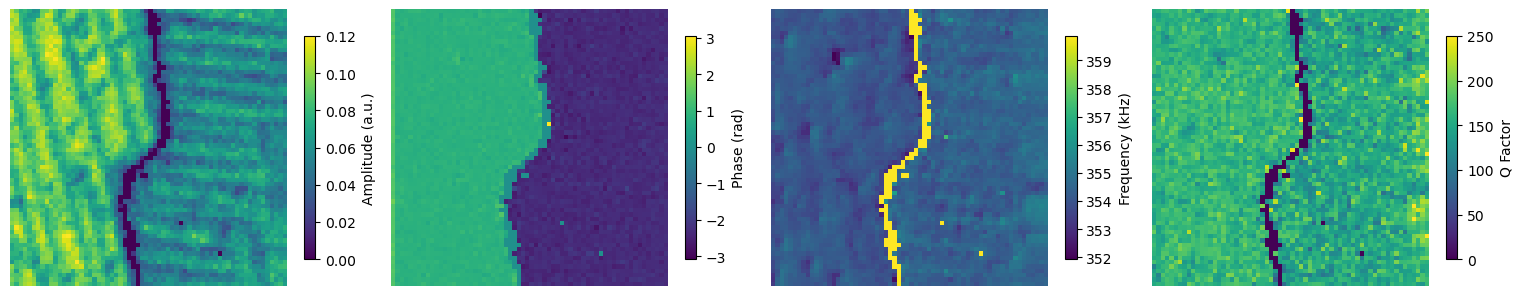

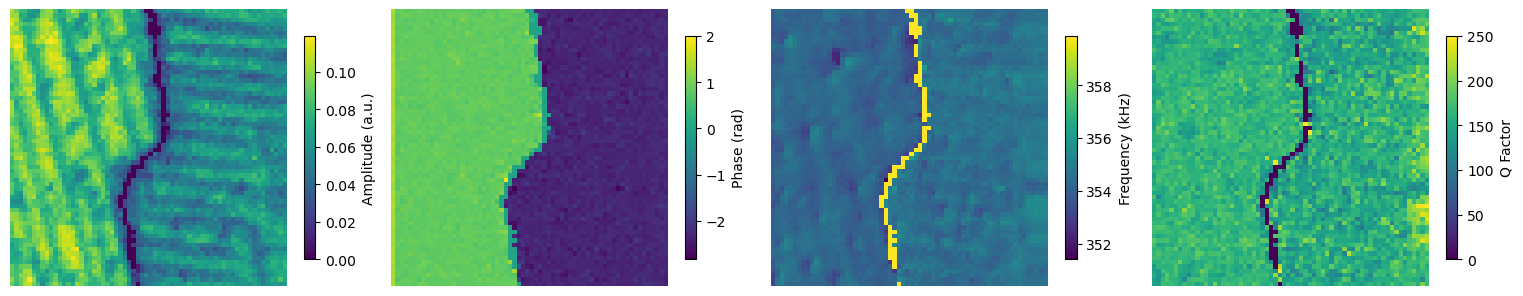

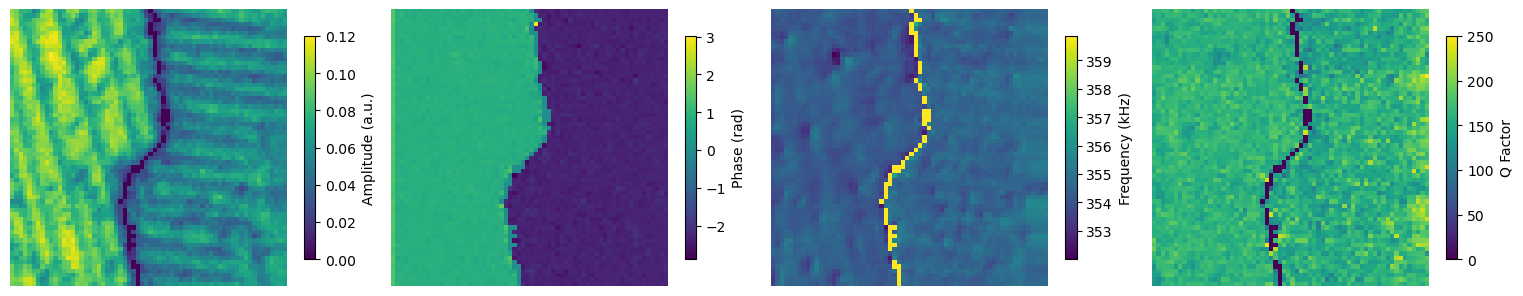

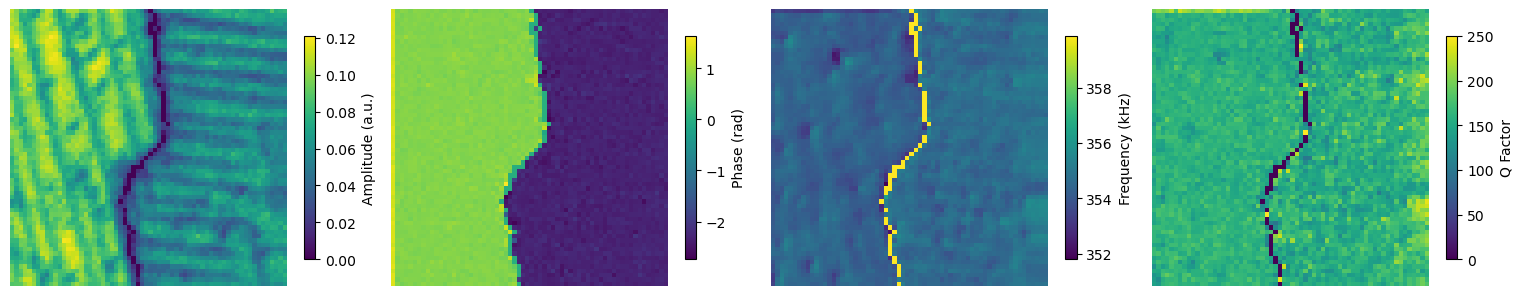

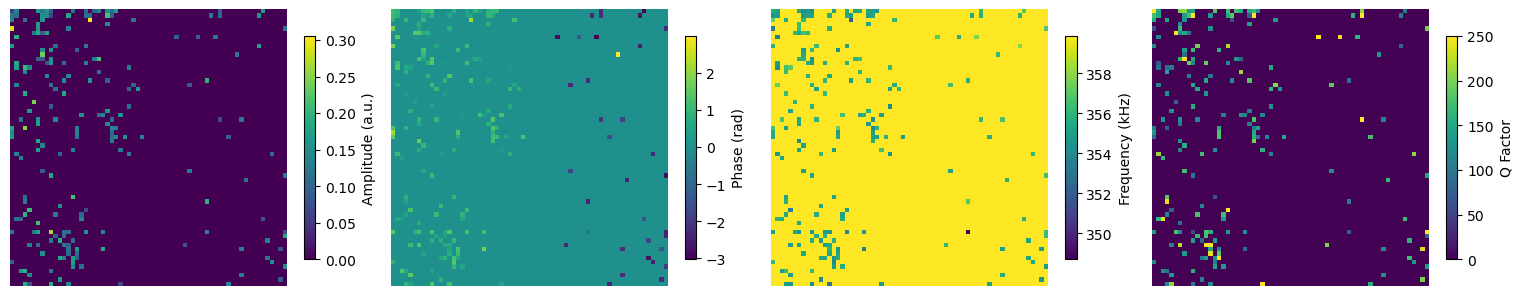

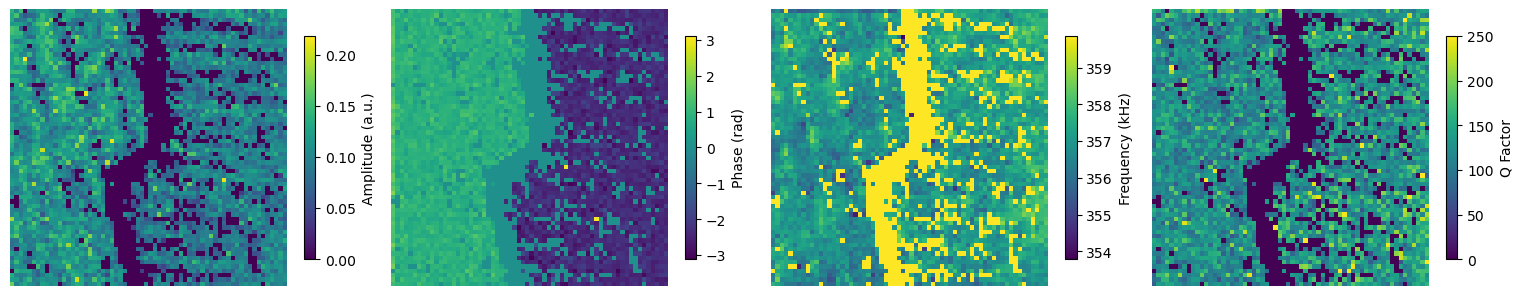

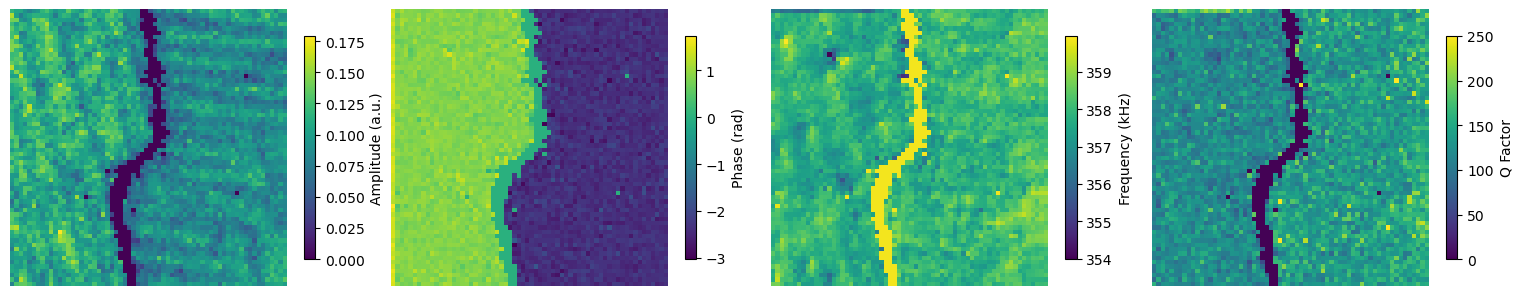

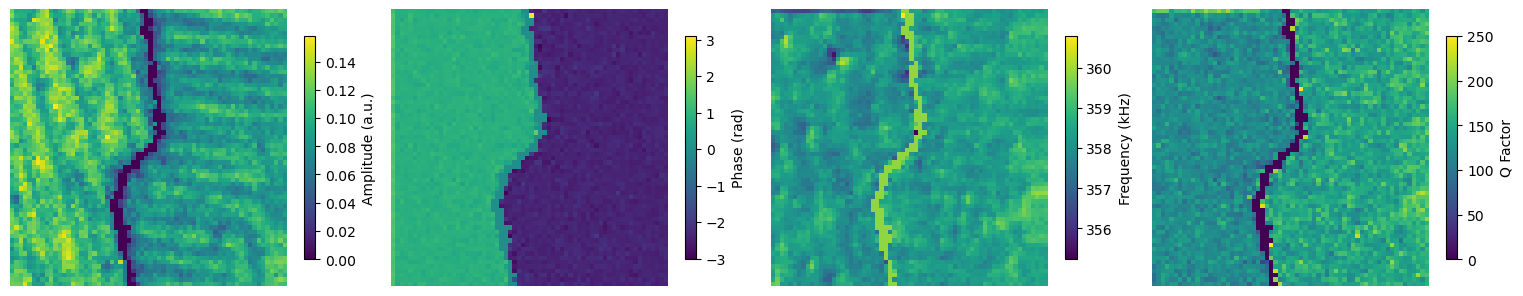

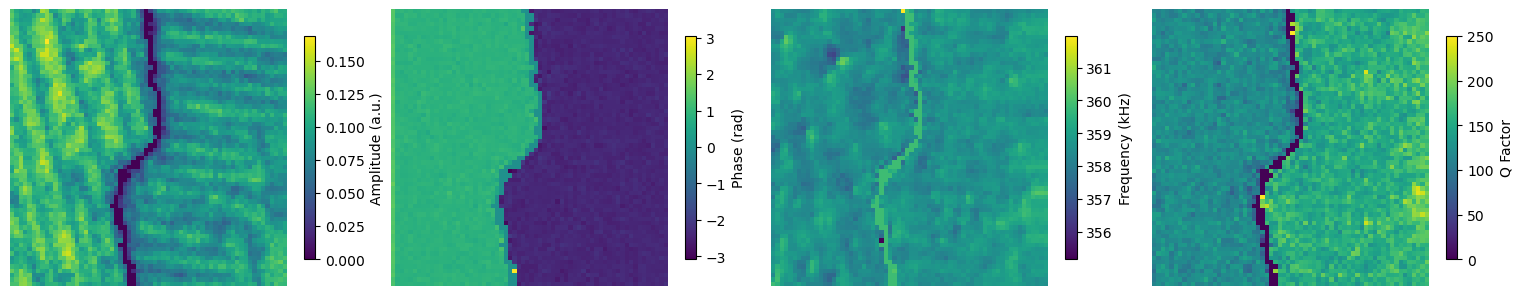

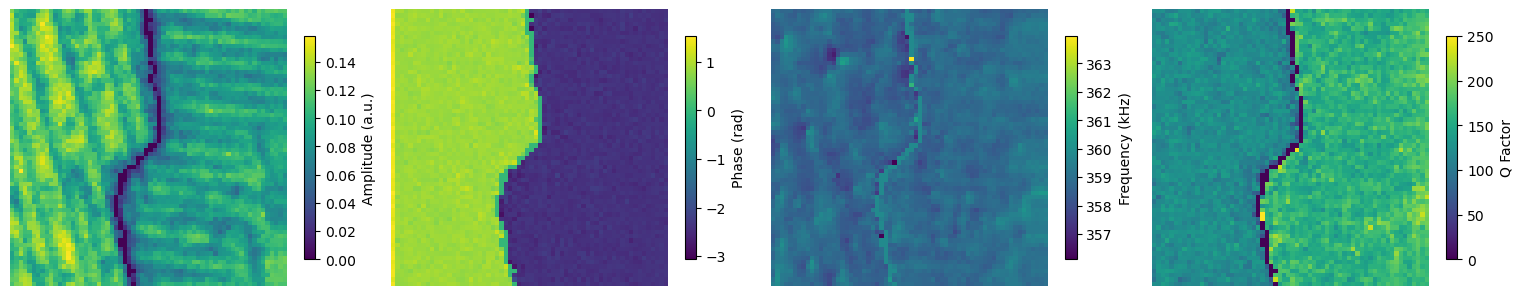

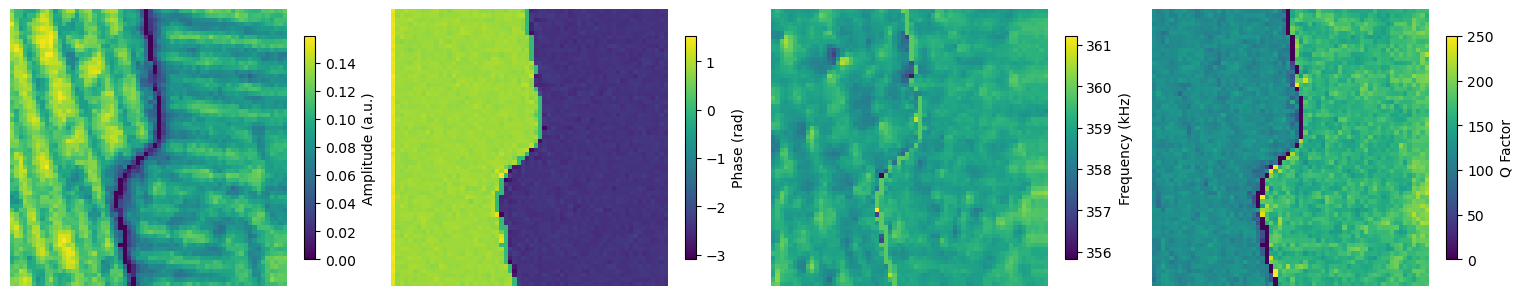

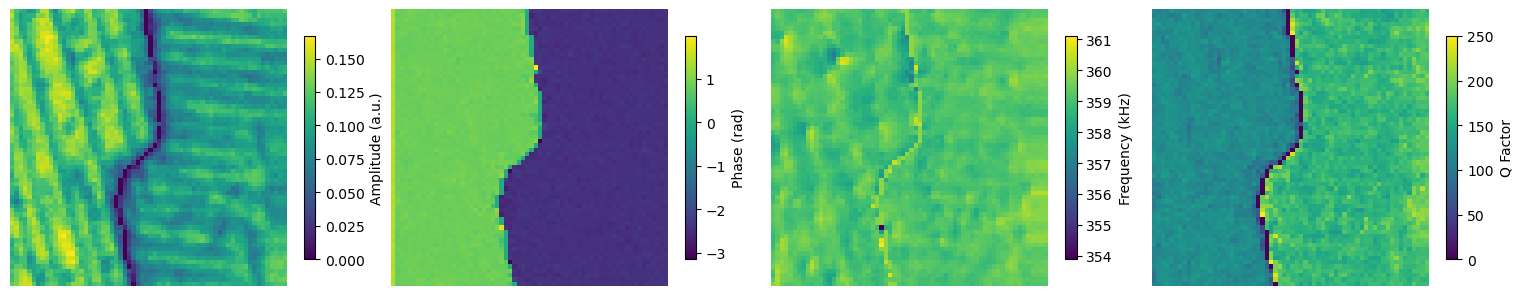

In [223]:
for i in range (count_imgs):

    fig, axs = plt.subplots(1, 4, figsize=(16, 4), dpi = 100)
    fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.99, wspace=0.1)
    cm = 'viridis'
    shrink = 0.6

    im0 = axs[0].imshow(amplitude[i, ]*1000, origin = "lower", interpolation='nearest', cmap=cm)
    fig.colorbar(im0, ax=axs[0], shrink = shrink, label = "Amplitude (a.u.)")
    axs[0].axis("off")

    im1 = axs[1].imshow(phase[i, ], origin = "lower", interpolation='nearest', cmap=cm)
    fig.colorbar(im1, ax=axs[1], shrink = shrink, label = "Phase (rad)")
    axs[1].axis("off")

    im2 = axs[2].imshow(frequency[i, ]/1000, origin = "lower", interpolation='nearest', cmap=cm)
    fig.colorbar(im2, ax=axs[2], shrink = shrink, label = "Frequency (kHz)")
    axs[2].axis("off")

    im3 = axs[3].imshow(qfactor[i, ], origin = "lower", vmin = 0, vmax = 250, interpolation='nearest', cmap=cm)
    fig.colorbar(im3, ax=axs[3], shrink = shrink, label = "Q Factor")
    axs[3].axis("off")
    
    plt.show()

Plot a specific channel together

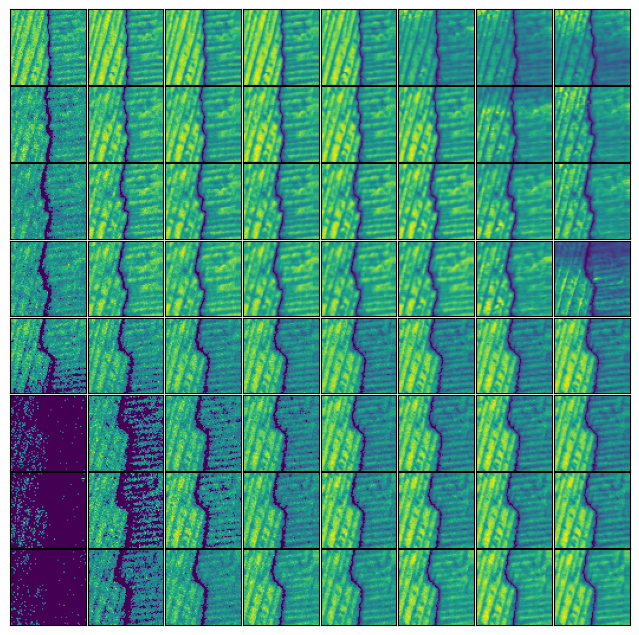

In [203]:
num_vac = 8
num_stp = 8
fig, axes = plt.subplots(num_y, num_x, figsize=(num_vac, num_stp),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.02, wspace=0.02))

for ax, i in zip(axes.flat, range(count_imgs)):
    ax.imshow(amplitude[i,]*1000) # We are plotting amplitude now, you can change the channel to phase, frequency,etc

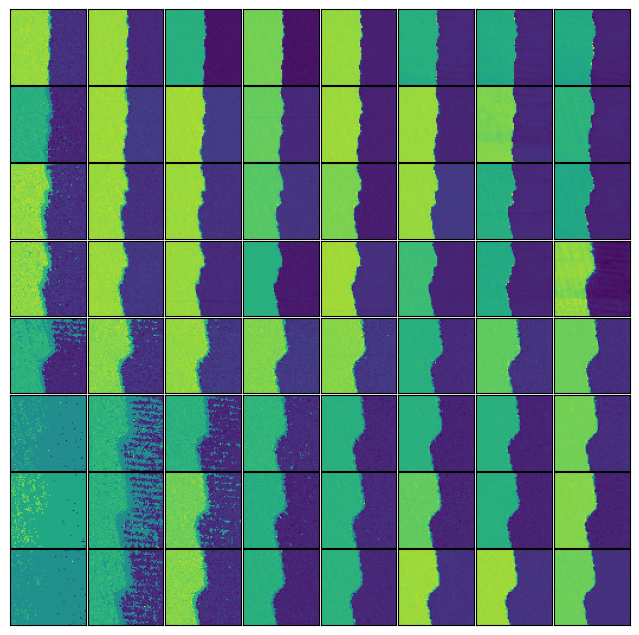

In [201]:
num_vac = 8
num_stp = 8
fig, axes = plt.subplots(num_y, num_x, figsize=(num_vac, num_stp),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.02, wspace=0.02))

for ax, i in zip(axes.flat, range(count_imgs)):
    ax.imshow(phase[i,], origin = "lower")